# Imports

In [1]:
import os
import time
import copy
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.regularizers import l1_l2, l1, l2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, LearningRateScheduler

# Constants

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 10
IMAGE_SIZE = 299
DATA_DIR = '../train449_test113'
TRAIN_DIR = DATA_DIR + '/train'
TEST_DIR = DATA_DIR + '/test'

# Label Index

In [3]:
train_root = Path(TRAIN_DIR)
img_labels = sorted(item.name for item in train_root.glob('*/') if item.is_dir())
label_to_index = dict((name, index) for index, name in enumerate(img_labels))
index_to_label = dict((index, name) for index, name in enumerate(img_labels))
print(label_to_index, index_to_label)

{'five': 0, 'four': 1, 'one': 2, 'three': 3, 'two': 4} {0: 'five', 1: 'four', 2: 'one', 3: 'three', 4: 'two'}


# Image Paths and Class Labels

In [4]:
all_image_paths = list(train_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
image_count = len(all_image_paths)
print(image_count)

2245


In [5]:
all_image_labels = [label_to_index[Path(path).parent.name]
                    for path in all_image_paths]
# Apply One-Hot Encoding
NUM_CLASSES = len(img_labels)
all_image_labels = to_categorical(all_image_labels, num_classes=NUM_CLASSES)
print(NUM_CLASSES)

5


# Image Loading Function

In [6]:
def load_and_resize_image(path, channels=3):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=channels)
    img = tf.image.resize(img, [IMAGE_SIZE, IMAGE_SIZE])
    return img

# Image Dataset and Input Pipeline Functions

In [7]:
def build_img_dataset(img_paths, labels):
    # image dataset
    path_ds = tf.data.Dataset.from_tensor_slices(img_paths)
    image_ds = path_ds.map(load_and_resize_image, num_parallel_calls=AUTOTUNE)
    # labels 
    label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(labels, tf.int8))
    # combine images and labels
    ds = tf.data.Dataset.zip((image_ds, label_ds))
    return ds

In [8]:
# apply xception preprocessing
def preprocess(img, label):
    img = tf.image.resize(img, [IMAGE_SIZE, IMAGE_SIZE])
    img = tf.transpose(img, [1, 0, 2])
    img = preprocess_input(img)
    return img, label

# apply image augmentation
def augment_img(img, label):
#     img = tf.image.random_flip_left_right(img)
    img = tf.image.random_flip_up_down(img)
    img = tf.image.random_brightness(img, .1)
    img = preprocess_input(img)
    return img, label

In [9]:
def build_dataset_pipeline(dataset, apply_aug=True):
    ds = dataset.cache()
    ds = ds.apply(tf.data.experimental.shuffle_and_repeat(buffer_size=image_count, seed=23))
    if apply_aug:
        ds = ds.map(augment_img)
    ds = ds.map(preprocess).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
    return ds

# Load Test Data

In [10]:
test_root = Path(TEST_DIR)
test_image_paths = list(test_root.glob('*/*'))
test_image_paths = [str(path) for path in test_image_paths]
test_image_count = len(test_image_paths)
print(test_image_count)
test_image_labels = [label_to_index[Path(path).parent.name]
                    for path in test_image_paths]
# Apply One-Hot Encoding
test_image_labels = to_categorical(test_image_labels, num_classes=NUM_CLASSES)
# Test Generator
test_ds = build_img_dataset(test_image_paths, test_image_labels)
test_generator = build_dataset_pipeline(test_ds, apply_aug=False)
#training steps
steps = tf.math.ceil(len(test_image_labels)/BATCH_SIZE)
steps = tf.cast(steps, tf.int16).numpy()

565


W0806 07:40:16.355981 13136 deprecation.py:323] From <ipython-input-9-88beae749a64>:3: shuffle_and_repeat (from tensorflow.python.data.experimental.ops.shuffle_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.data.Dataset.shuffle(buffer_size, seed)` followed by `tf.data.Dataset.repeat(count)`. Static tf.data optimizations will take care of using the fused implementation.
W0806 07:40:16.357975 13136 deprecation.py:323] From c:\users\peter\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\data\util\random_seed.py:58: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


# Helper Functions for Callbacks

In [11]:
# Helper function for Tensorboard callback
logs_path = 'xception_logs'
root_logdir = os.path.join(os.curdir, logs_path)
def get_run_logdir(k_fold):
    run_id = time.strftime(f"run_%Y_%m_%d-%H_%M_%S_kfold.{k_fold}")
    return os.path.join(root_logdir, run_id)

# Helper function for learning rate callback
def schedule(epoch):
    if epoch < 15:
        return .01
    elif epoch < 28:
        return .003
    elif epoch < 50:
        return .001
    else:
        return .0003

# Xception Model

In [12]:
def build_xception(learning_rate=0.2, freeze_index=132, model=None):
    
    if model is None:
        base_model = Xception(weights="imagenet", include_top=False)
        avg = GlobalAveragePooling2D()(base_model.output)
        drop = Dropout(.5)(avg)
        output = Dense(NUM_CLASSES, 
                       activation="softmax", 
                       kernel_initializer="glorot_uniform", 
                       kernel_regularizer=l1_l2(.003, .4))(drop)
        model = Model(inputs=base_model.input, outputs=output)
    
    for i, layer in enumerate(model.layers):
        if i < freeze_index:   
            layer.trainable = False
        
    optimizer = SGD(lr=learning_rate, momentum=0.9)
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    
    return model

In [13]:
def fit_xception(train_generator, valid_generator, steps_per_epoch, validation_steps, 
                 callbacks, learning_rate=0.2, freeze_index=132, model=None, EPOCHS=100):
    model = build_xception(learning_rate=learning_rate, freeze_index=freeze_index, model=model)
    history = model.fit(
        train_generator,
        epochs = EPOCHS,
        steps_per_epoch=steps_per_epoch,
        validation_data=valid_generator,
        validation_steps=validation_steps,
        verbose=1,
        callbacks=callbacks)
    return model, history

# K-fold Cross Validation

In [14]:
def train_model_cross_val(images, labels, checkpoint_path, learning_rate=0.2, freeze_index=132, model=None, n_folds=5):
    evaluations = []
    model_history = []
    test_size = 1/n_folds
    start_time = time.time()
    for i in range(n_folds):
        new_model = None
        new_history = None
        print("Training on Fold: ",i+1)
        X_train, X_valid, y_train, y_valid = train_test_split(images, labels, test_size=test_size, 
                                                   random_state = np.random.randint(1,1000, 1)[0])
        train_ds = build_img_dataset(X_train, y_train)
        valid_ds = build_img_dataset(X_valid, y_valid)
        train_generator = build_dataset_pipeline(train_ds)
        valid_generator = build_dataset_pipeline(valid_ds, apply_aug=False)
        
        steps_per_epoch = tf.math.ceil(len(y_train)/BATCH_SIZE)
        steps_per_epoch = tf.cast(steps_per_epoch, tf.int16).numpy()
        validation_steps = tf.math.ceil(len(y_valid)/BATCH_SIZE)
        validation_steps = tf.cast(validation_steps, tf.int16).numpy()
        
        early_stopping_cb = None
        early_stopping_cb = EarlyStopping(patience=10, restore_best_weights=True)
        checkpoint_cb = None
        checkpoint_cb = ModelCheckpoint(
            filepath=checkpoint_path + f'/xception.{i}' + '.{epoch:02d}-{val_loss:.6f}.h5', 
            verbose=1, save_best_only=True)
        run_logdir = None
        tensorboard_cb = None
        run_logdir = get_run_logdir(i)
        tensorboard_cb = TensorBoard(run_logdir)
        lr_scheduler_cb = None
        lr_scheduler_cb = LearningRateScheduler(schedule)
        callbacks = [early_stopping_cb, checkpoint_cb, tensorboard_cb, lr_scheduler_cb]
        
        new_model, new_history  = fit_xception(
            train_generator, 
            valid_generator, 
            steps_per_epoch, 
            validation_steps,
            callbacks=callbacks,
            learning_rate=learning_rate,
            freeze_index=freeze_index,
            model=model
        )
        evaluation_results = new_model.evaluate(test_generator, steps=steps)
        evaluations.append({ 
            new_model.metrics_names[0]: evaluation_results[0],
            new_model.metrics_names[1]: evaluation_results[1]
        })
        model_history.append(new_history)
        
        print("======="*12, end="\n\n\n")
    end_time = time.time() - start_time
    return evaluations, model_history, end_time

# Train Model

In [15]:
checkpoint_path = 'xception_checkpoints'

evaluations, model_history, train_duration = train_model_cross_val(all_image_paths, 
                                                                   all_image_labels, 
                                                                   checkpoint_path=checkpoint_path,
                                                                   learning_rate=0.01,
                                                                   freeze_index=66)
print(f'train_duration: {train_duration}s')

Training on Fold:  1
Epoch 1/100
  1/180 [..............................] - ETA: 2:15:45 - loss: 6.2891 - accuracy: 0.3000

W0806 00:11:56.460828 13480 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (0.313819). Check your callbacks.


179/180 [============================>.] - ETA: 0s - loss: 1.9149 - accuracy: 0.4966
Epoch 00001: val_loss improved from inf to 1.10400, saving model to xception_checkpoints/xception.0.01-1.104003.h5
180/180 [==============================] - 81s 451ms/step - loss: 1.9107 - accuracy: 0.4978 - val_loss: 1.1040 - val_accuracy: 0.7333
Epoch 2/100
179/180 [============================>.] - ETA: 0s - loss: 1.0957 - accuracy: 0.7709
Epoch 00002: val_loss did not improve from 1.10400
180/180 [==============================] - 33s 182ms/step - loss: 1.0938 - accuracy: 0.7717 - val_loss: 1.2196 - val_accuracy: 0.6622
Epoch 3/100
179/180 [============================>.] - ETA: 0s - loss: 0.8638 - accuracy: 0.8732
Epoch 00003: val_loss improved from 1.10400 to 0.87104, saving model to xception_checkpoints/xception.0.03-0.871039.h5
180/180 [==============================] - 33s 186ms/step - loss: 0.8652 - accuracy: 0.8728 - val_loss: 0.8710 - val_accuracy: 0.8711
Epoch 4/100
179/180 [=============

Epoch 27/100
179/180 [============================>.] - ETA: 0s - loss: 0.2857 - accuracy: 1.0000
Epoch 00027: val_loss improved from 0.43572 to 0.43269, saving model to xception_checkpoints/xception.0.27-0.432687.h5
180/180 [==============================] - 33s 186ms/step - loss: 0.2868 - accuracy: 1.0000 - val_loss: 0.4327 - val_accuracy: 0.9378
Epoch 28/100
179/180 [============================>.] - ETA: 0s - loss: 0.2980 - accuracy: 0.9994
Epoch 00028: val_loss improved from 0.43269 to 0.42438, saving model to xception_checkpoints/xception.0.28-0.424378.h5
180/180 [==============================] - 33s 186ms/step - loss: 0.2977 - accuracy: 0.9994 - val_loss: 0.4244 - val_accuracy: 0.9356
Epoch 29/100
179/180 [============================>.] - ETA: 0s - loss: 0.2825 - accuracy: 0.9994
Epoch 00029: val_loss did not improve from 0.42438
180/180 [==============================] - 33s 183ms/step - loss: 0.2824 - accuracy: 0.9994 - val_loss: 0.4257 - val_accuracy: 0.9333
Epoch 30/100
17

W0806 00:38:14.923027 13480 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (0.310853). Check your callbacks.


179/180 [============================>.] - ETA: 0s - loss: 1.8939 - accuracy: 0.5078
Epoch 00001: val_loss improved from inf to 1.06160, saving model to xception_checkpoints/xception.1.01-1.061597.h5
180/180 [==============================] - 100s 558ms/step - loss: 1.8897 - accuracy: 0.5089 - val_loss: 1.0616 - val_accuracy: 0.7267
Epoch 2/100
179/180 [============================>.] - ETA: 0s - loss: 1.0385 - accuracy: 0.8073
Epoch 00002: val_loss improved from 1.06160 to 0.84728, saving model to xception_checkpoints/xception.1.02-0.847275.h5
180/180 [==============================] - 33s 185ms/step - loss: 1.0402 - accuracy: 0.8056 - val_loss: 0.8473 - val_accuracy: 0.8556
Epoch 3/100
179/180 [============================>.] - ETA: 0s - loss: 0.8302 - accuracy: 0.8737
Epoch 00003: val_loss improved from 0.84728 to 0.84281, saving model to xception_checkpoints/xception.1.03-0.842808.h5
180/180 [==============================] - 33s 185ms/step - loss: 0.8314 - accuracy: 0.8728 - val_l

W0806 01:07:13.221827 13480 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (0.315097). Check your callbacks.


179/180 [============================>.] - ETA: 0s - loss: 1.8565 - accuracy: 0.5447
Epoch 00001: val_loss improved from inf to 1.23441, saving model to xception_checkpoints/xception.2.01-1.234410.h5
180/180 [==============================] - 127s 703ms/step - loss: 1.8554 - accuracy: 0.5456 - val_loss: 1.2344 - val_accuracy: 0.6778
Epoch 2/100
179/180 [============================>.] - ETA: 0s - loss: 1.0242 - accuracy: 0.8006
Epoch 00002: val_loss improved from 1.23441 to 1.16345, saving model to xception_checkpoints/xception.2.02-1.163452.h5
180/180 [==============================] - 34s 187ms/step - loss: 1.0281 - accuracy: 0.7983 - val_loss: 1.1635 - val_accuracy: 0.7067
Epoch 3/100
179/180 [============================>.] - ETA: 0s - loss: 0.8264 - accuracy: 0.8810
Epoch 00003: val_loss improved from 1.16345 to 0.87004, saving model to xception_checkpoints/xception.2.03-0.870044.h5
180/180 [==============================] - 34s 186ms/step - loss: 0.8252 - accuracy: 0.8811 - val_l

57/57 [==============================] - 8s 140ms/step - loss: 0.3855 - accuracy: 0.9526


Training on Fold:  4
Epoch 1/100
  1/180 [..............................] - ETA: 6:01:58 - loss: 6.3568 - accuracy: 0.2000

W0806 01:24:37.722828 13480 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (0.310852). Check your callbacks.


179/180 [============================>.] - ETA: 0s - loss: 1.9195 - accuracy: 0.4961
Epoch 00001: val_loss improved from inf to 1.45076, saving model to xception_checkpoints/xception.3.01-1.450762.h5
180/180 [==============================] - 157s 871ms/step - loss: 1.9139 - accuracy: 0.4989 - val_loss: 1.4508 - val_accuracy: 0.5400
Epoch 2/100
179/180 [============================>.] - ETA: 0s - loss: 1.0930 - accuracy: 0.7698
Epoch 00002: val_loss improved from 1.45076 to 0.99568, saving model to xception_checkpoints/xception.3.02-0.995679.h5
180/180 [==============================] - 34s 186ms/step - loss: 1.0920 - accuracy: 0.7700 - val_loss: 0.9957 - val_accuracy: 0.7933
Epoch 3/100
179/180 [============================>.] - ETA: 0s - loss: 0.8570 - accuracy: 0.8615
Epoch 00003: val_loss improved from 0.99568 to 0.79830, saving model to xception_checkpoints/xception.3.03-0.798305.h5
180/180 [==============================] - 34s 186ms/step - loss: 0.8612 - accuracy: 0.8606 - val_l

179/180 [============================>.] - ETA: 0s - loss: 0.2822 - accuracy: 0.9989
Epoch 00054: val_loss did not improve from 0.39334
180/180 [==============================] - 33s 184ms/step - loss: 0.2823 - accuracy: 0.9989 - val_loss: 0.3978 - val_accuracy: 0.9378
Epoch 55/100
179/180 [============================>.] - ETA: 0s - loss: 0.2807 - accuracy: 0.9994
Epoch 00055: val_loss did not improve from 0.39334
180/180 [==============================] - 33s 184ms/step - loss: 0.2807 - accuracy: 0.9994 - val_loss: 0.3983 - val_accuracy: 0.9378
Epoch 56/100
179/180 [============================>.] - ETA: 0s - loss: 0.2721 - accuracy: 1.0000
Epoch 00056: val_loss did not improve from 0.39334
180/180 [==============================] - 33s 184ms/step - loss: 0.2727 - accuracy: 1.0000 - val_loss: 0.3990 - val_accuracy: 0.9378
Epoch 57/100
179/180 [============================>.] - ETA: 0s - loss: 0.2848 - accuracy: 1.0000
Epoch 00057: val_loss did not improve from 0.39334
180/180 [======

W0806 02:01:56.784446 13480 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (0.312819). Check your callbacks.


179/180 [============================>.] - ETA: 0s - loss: 1.8930 - accuracy: 0.4972
Epoch 00001: val_loss improved from inf to 1.29793, saving model to xception_checkpoints/xception.4.01-1.297934.h5
180/180 [==============================] - 184s 1s/step - loss: 1.8885 - accuracy: 0.4989 - val_loss: 1.2979 - val_accuracy: 0.7311
Epoch 2/100
179/180 [============================>.] - ETA: 0s - loss: 1.0937 - accuracy: 0.7905
Epoch 00002: val_loss improved from 1.29793 to 1.08961, saving model to xception_checkpoints/xception.4.02-1.089614.h5
180/180 [==============================] - 33s 183ms/step - loss: 1.0927 - accuracy: 0.7911 - val_loss: 1.0896 - val_accuracy: 0.7933
Epoch 3/100
179/180 [============================>.] - ETA: 0s - loss: 0.8226 - accuracy: 0.8883
Epoch 00003: val_loss improved from 1.08961 to 0.77073, saving model to xception_checkpoints/xception.4.03-0.770731.h5
180/180 [==============================] - 33s 183ms/step - loss: 0.8221 - accuracy: 0.8878 - val_loss

Epoch 27/100
179/180 [============================>.] - ETA: 0s - loss: 0.3026 - accuracy: 0.9983
Epoch 00027: val_loss improved from 0.36861 to 0.35126, saving model to xception_checkpoints/xception.4.27-0.351262.h5
180/180 [==============================] - 33s 184ms/step - loss: 0.3024 - accuracy: 0.9983 - val_loss: 0.3513 - val_accuracy: 0.9600
Epoch 28/100
179/180 [============================>.] - ETA: 0s - loss: 0.2915 - accuracy: 0.9989
Epoch 00028: val_loss did not improve from 0.35126
180/180 [==============================] - 33s 182ms/step - loss: 0.2920 - accuracy: 0.9989 - val_loss: 0.3581 - val_accuracy: 0.9556
Epoch 29/100
179/180 [============================>.] - ETA: 0s - loss: 0.2919 - accuracy: 0.9972
Epoch 00029: val_loss improved from 0.35126 to 0.34951, saving model to xception_checkpoints/xception.4.29-0.349509.h5
180/180 [==============================] - 33s 184ms/step - loss: 0.2921 - accuracy: 0.9972 - val_loss: 0.3495 - val_accuracy: 0.9489
Epoch 30/100
17

# Check Mean Evaluation

In [18]:
evaluations_len = len(evaluations)
mean_loss = 0
mean_acc = 0
for evaluation in evaluations:
    mean_loss += evaluation['loss']
    mean_acc += evaluation['accuracy']
print(evaluations)
print('mean loss', mean_loss/evaluations_len)
print('mean accuracy', mean_acc/evaluations_len)

[{'loss': 0.3733244404981011, 'accuracy': 0.9526316}, {'loss': 0.38599197723363576, 'accuracy': 0.94385964}, {'loss': 0.3854596567781348, 'accuracy': 0.9526316}, {'loss': 0.35827355243657766, 'accuracy': 0.95789474}, {'loss': 0.3662434016403399, 'accuracy': 0.9508772}]
mean loss 0.37385860571735785
mean accuracy 0.951578950881958


# Model Testing

In [11]:
# load best model
model = load_model(filepath='xception_checkpoints/xception.4.31-0.343292.h5')

In [12]:
# Evaluate top-1 test data accuracy
evaluation_results = model.evaluate(test_generator, steps=steps)
print(model.metrics_names[0], evaluation_results[0])
print(model.metrics_names[1], evaluation_results[1])

57/57 [==============================] - 13s 226ms/step - loss: 0.3662 - accuracy: 0.9509
loss 0.3662434016403399
accuracy 0.9508772


In [13]:
# Display Test Predictions
def index_to_class(index, classes):
    return classes[index]

def decode_predictions(y_probs, classes, top=3):
    top_probs = np.sort(y_probs, axis=1)[:, ::-1][:, :top] # desc
    top_indeces = np.argsort(y_probs, axis=1)[:, ::-1][:, :top] # desc
    vfunc = np.vectorize(index_to_class)
    top_cat = vfunc(top_indeces, classes)
    return [top_probs, top_cat]

W0806 07:42:06.026820 13136 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image #1


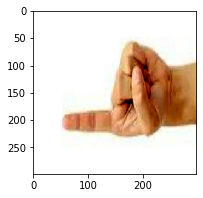

W0806 07:42:06.168432 13136 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


    one          97.76%
    three        0.61%
    four         0.60%

Image #2


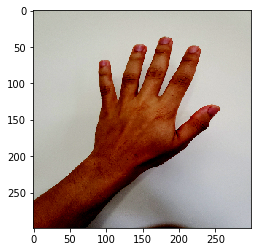

W0806 07:42:06.330000 13136 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


    five         96.80%
    three        0.86%
    four         0.82%

Image #3


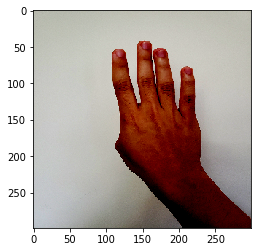

W0806 07:42:06.479601 13136 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


    four         97.62%
    three        0.65%
    five         0.65%

Image #4


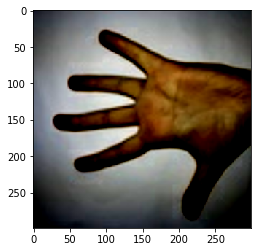

W0806 07:42:06.627205 13136 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


    five         96.62%
    three        0.91%
    four         0.87%

Image #5


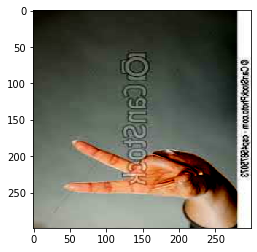

W0806 07:42:06.756859 13136 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


    two          98.68%
    four         0.36%
    three        0.36%

Image #6


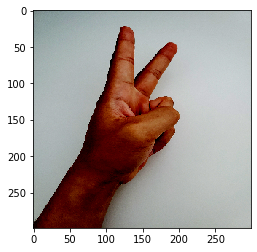

W0806 07:42:06.907457 13136 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


    two          84.92%
    three        3.95%
    one          3.91%

Image #7


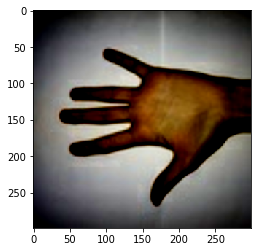

W0806 07:42:07.060049 13136 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


    five         96.68%
    three        0.89%
    four         0.85%

Image #8


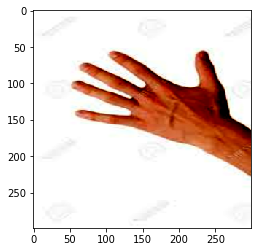

W0806 07:42:07.184715 13136 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


    four         90.08%
    three        2.76%
    five         2.65%

Image #9


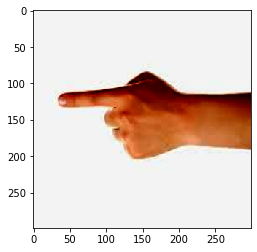

W0806 07:42:07.303398 13136 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


    one          97.11%
    three        0.78%
    four         0.77%

Image #10


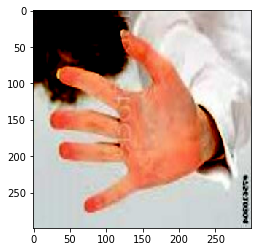

    five         72.13%
    four         10.87%
    three        6.36%



In [14]:
# display top 3 predictions for one batch
for images, labels in test_generator.take(1):
    test_batch = images.numpy()
    y_probs = model.predict(test_batch)
    top_k = 3
    top_k_probs, top_k_labels = decode_predictions(y_probs, index_to_label, top=top_k)
    plt.figure(figsize=(3,3))
    for i in range(BATCH_SIZE):
        print(f"Image #{i+1}")
        plt.imshow(test_batch[i])
        plt.show()
        for j in range(top_k):
            print("    {:12s} {:.2f}%".format(top_k_labels[i][j], top_k_probs[i][j] * 100))
        print()

# Generate Confusion Matrix

In [15]:
y_preds = np.zeros(shape=(steps*BATCH_SIZE,NUM_CLASSES))
y_true = np.zeros(shape=(steps*BATCH_SIZE,NUM_CLASSES))
i = 0
for images, labels in test_generator.take(steps):
    test_batch = images.numpy()
    y_probs = model.predict(test_batch)
    start = i*BATCH_SIZE
    end = start + BATCH_SIZE
    y_preds[start:end] = y_probs
    y_true[start:end] = labels
    i += 1

In [16]:
y_preds_top1 = np.argmax(y_preds, axis=1)
y_true_top1 = np.argmax(y_true, axis=1)

In [17]:
confusion_matrix = tf.math.confusion_matrix(y_true_top1, y_preds_top1, NUM_CLASSES)

Text(0.5, 159.0, 'Predicted Labels')

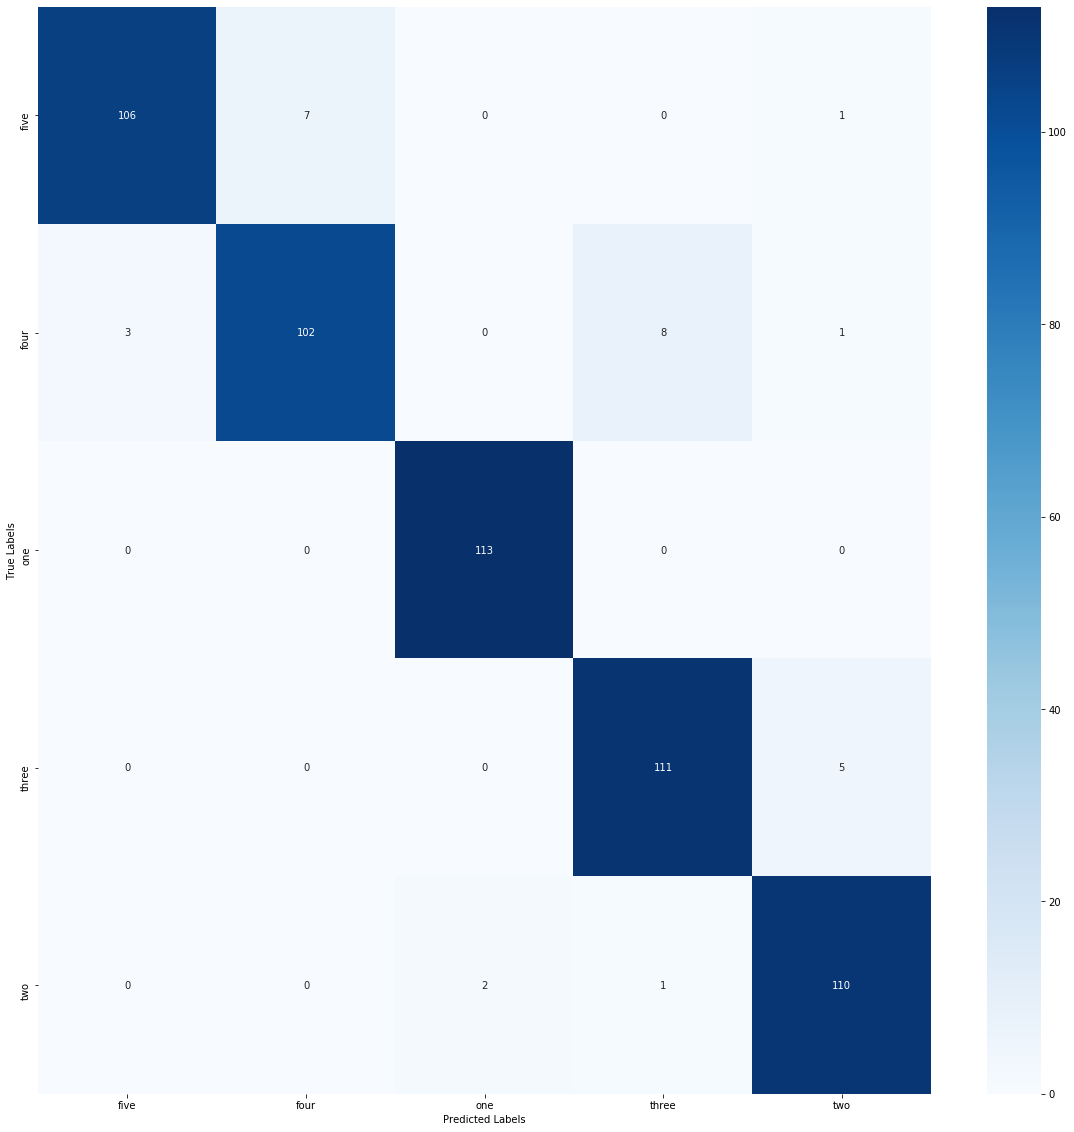

In [18]:
plt.figure(figsize=(20,20))
ax = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=img_labels, yticklabels=img_labels)
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')

In [19]:
recall = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis = 1)
precision = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis = 0)
data = {'Recall':recall.round(4), 'Precision':precision.round(4)} 
df = pd.DataFrame(data, index = img_labels) 
df

,Recall,Precision
five,0.9298,0.9725
four,0.8947,0.9358
one,1.0000,0.9826
three,0.9569,0.9250
two,0.9735,0.9402


# Convert Model to tflite

In [20]:
# convert model to tflite
model_file = 'xception_checkpoints/xception.4.31-0.343292.h5'
converter = tf.compat.v1.lite.TFLiteConverter.from_keras_model_file(
        model_file, input_shapes={model.layers[0].name: [1, IMAGE_SIZE, IMAGE_SIZE, 3]})
tflite_model = converter.convert()
open("xception.tflite", "wb").write(tflite_model)

83208600

In [21]:
# convert model to quantized tflite (8-bits precision)
converter = tf.compat.v1.lite.TFLiteConverter.from_keras_model_file(
        model_file, input_shapes={model.layers[0].name: [1, IMAGE_SIZE, IMAGE_SIZE, 3]})
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()
open("xception-quant.tflite", "wb").write(tflite_model)

20931024